games.csv - датасет игр из steam

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [23]:
df = pd.read_csv("..//static//csv//games.csv")

# df['date_release'] = pd.to_datetime(df['date_release'])
# # Разделение даты на год, месяц и день
# df['year'] = df['date_release'].dt.year
# df['month'] = df['date_release'].dt.month
# df['day'] = df['date_release'].dt.day

# # Удаляем исходный столбец 'date', если он больше не нужен
# df.drop('date', axis=1, inplace=True)

Входные переменные: user_reviews (кол-во отзывов игроков; reviews в коде), price_original (цена на момент выхода; price в коде)

Выходная перменная: positive_ratio (отношение положительных отзывов к негативным; pos в коде)

In [24]:
from datetime import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
from skfuzzy import control as ctrl
import skfuzzy as fuzz

#входная переменная кол-ва отзывов с таким универсумом (от 0 до 100k)
reviews = ctrl.Antecedent(np.arange(0, 100000, 1), "reviews")

#входная переменная цены с таким универсумом (от 0 до 100 долларов)
price = ctrl.Antecedent(np.arange(0, 100, 0.01), "price")

#удалить пару игр, у которых цена больше 100 долларов, чтобы графики норм. были
df = df[df['price_original'] <= 100]

#удалить несколько игр, у которых больше 100k отзывов, чтобы графики норм. были
df = df[df['user_reviews'] <= 100000]

#выходная переменная позитивности с таким универсумом (от 0 до 100)
pos = ctrl.Consequent(np.arange(0, 100, 1), "pos")

## Лингвистические переменные и их визуализация

c:\AI labs\aimenv\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


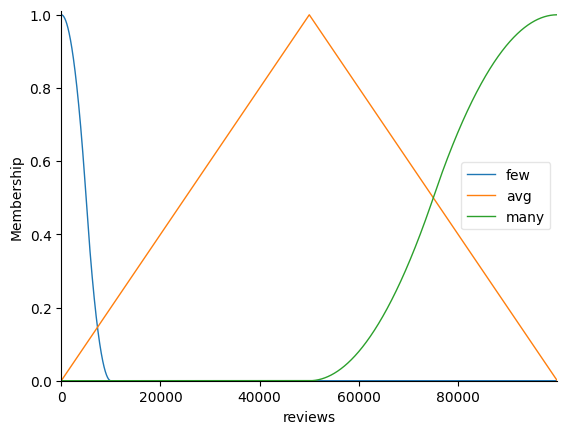

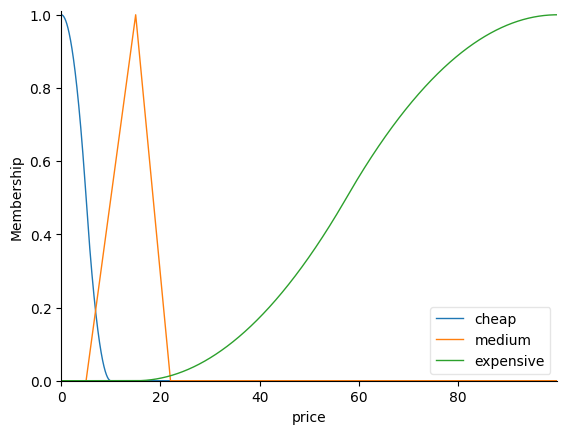

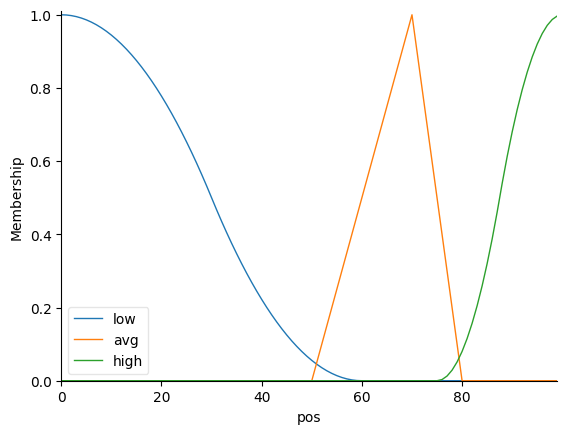

In [ ]:
#ЛИНГВИСТИЧЕСКАЯ ПЕР. КОЛ-ВО ОТЗЫВОВ

#определял примерные диапазоны для кол-ва отзывов с помощью boxplot:
# plt.figure(figsize=(12, 8))
# df_temp = df[df['user_reviews'] < 100000] 
# plt.boxplot(x=df_temp['user_reviews'])
# plt.show()

#автоматическое формирование нечёт. переменной отзывов, но с поправкой для many (s - ф-ия) 
reviews.automf(3, variable_type="quant", names=['few', 'avg', 'many'])
reviews["few"] = fuzz.zmf(reviews.universe, 0, 10000)

reviews["many"] = fuzz.smf(reviews.universe, reviews.universe.max()/2, reviews.universe.max())
reviews.view()

#СТАРЫЙ КОД
#---------------------------------------------------------------------------
# #до 15 обзоров - мало
# #z-функция
# reviews["few"] = fuzz.zmf(reviews.universe, 0, 15)

# #10-40 обзоров - средне
# #треуг. ф-ия
# # 10  - левая вершина треугольника
# # 25 - верхняя вершина
# # 40 - правая вершина
# reviews["average"] = fuzz.trimf(reviews.universe, [10, 25, 40]) 

# #больше 30 обзоров - много
# #s-функция
# reviews["many"] = fuzz.smf(reviews.universe, 30, reviews.universe.max())

# reviews.view()

#---------------------------------------------------------------------------



#ЛИНГВИСТИЧЕСКАЯ ПЕР. ЦЕНА

#определял примерные диапазоны для цены с помощью boxplot:
# plt.figure(figsize=(12, 8))
# df_temp = df[df['price_original'] < 60]
# plt.boxplot(x=df_temp['price_original'])
# plt.show()

#От 0 до 10 долларов можно считать дёшево (переводил на рубли)
#z-функция
# price["cheap"] = fuzz.zmf(price.universe, 0, 10)
price["cheap"] = fuzz.zmf(price.universe, 0, 12)

#от 5 до 22 долларов можно считать средне (переводил на рубли)
#треуг. ф-ия
# 5  - левая вершина треугольника
# 15 - верхняя вершина
# 22 - правая вершина
# price["medium"] = fuzz.trimf(price.universe, [5, 15, 22])
price["medium"] = fuzz.trimf(price.universe, [5, 16, 22])

#больше 15 долларов можно считать дорого (переводил на рубли)
#s-функция
price["expensive"] = fuzz.smf(price.universe, 15, price.universe.max())

price.view()


#ЛИНГВИСТИЧЕСКАЯ ПЕР. СООТНОШЕНИЕ ПОЛОЖ./НЕГАТИВ. ОТЗЫВОВ
#до 60% можно считать низким отношением позитивных к негативным

pos["low"] = fuzz.zmf(pos.universe, 0, 60)

#от 50 до 80 можно считать средним
pos["avg"] = fuzz.trimf(pos.universe, [50, 70, 80])

#от 75 можно считать высоким
pos["high"] = fuzz.smf(pos.universe, 75, 100)



pos.view()

## База нечётких правил

In [33]:
rule1 = ctrl.Rule(reviews['many'] & price['cheap'], pos['high'])
rule2 = ctrl.Rule(reviews['many'] & price['medium'], pos['high']) #avg
rule3 = ctrl.Rule(reviews['many'] & price['expensive'], pos['high']) 

rule4 = ctrl.Rule(reviews['few'] & price['cheap'], pos['high']) #avg
rule5 = ctrl.Rule(reviews['few'] & price['medium'], pos['avg']) #avg
rule6 = ctrl.Rule(reviews['few'] & price['expensive'], pos['low'])

rule7 = ctrl.Rule(reviews['avg'] & price['cheap'], pos['avg'])
rule8 = ctrl.Rule(reviews['avg'] & price['medium'], pos['high'])
rule9 = ctrl.Rule(reviews['avg'] & price['expensive'], pos['avg'])



#ЗДЕСЬ ДОПОЛНИТЬ, ЕСЛИ БУДЕТ ДОП. ПРАВИЛО:
fuzzy_rules = [
    rule1,
    rule2,
    rule3,
    rule4,
    rule5,
    rule6,
    rule7,
    rule8,
    rule9
]

fuzzy_sys = ctrl.ControlSystemSimulation(ctrl.ControlSystem(fuzzy_rules))

#ТУТ ПОМЕНЯТЬ НАЗВАНИЯ СТОЛБЦОВ И НЕЧЁТКИХ ПЕРЕМЕННЫХ НА СВОИ
def fuzzy_pred(row):
    # al - нечёт. пер. ; al2o3 - столбец датасета
    fuzzy_sys.input["reviews"] = row["user_reviews"]
    fuzzy_sys.input["price"] = row["price_original"]
    fuzzy_sys.compute()
    # return fuzzy_sys.output["positive_ratio"]
    return fuzzy_sys.output["pos"]

from sklearn.model_selection import train_test_split
#РАЗДЕЛИТЬ ДАТАСЕТ НА ОБУЧАЮЩУЮ, ТЕСТОВУЮ ВЫБОРКИ
#Тестирование нечеткой системы на тестовой выборке
# Разделение данных на обучающую и тестовую выборки
X = df[['user_reviews', 'price_original']]
y = df['positive_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

test = pd.concat([X_test, y_test], axis=1)


print(test)

result_test = test.copy()
result_test["positive_ratio_pred"] = result_test.apply(fuzzy_pred, axis=1)
result_test

       user_reviews  price_original  positive_ratio
15251            46            0.99              95
13770           491            6.99              83
21390           365            0.00              76
16365            55            2.99              96
49100            78            0.00              74
...             ...             ...             ...
2652             55           14.99              74
30351            41            9.99              82
1810           4598           59.99              92
27959           115            2.99              73
2864             15            4.99              86

[10142 rows x 3 columns]


user_reviews  price_original  positive_ratio  positive_ratio_pred
15251            46            0.99              95            92.044490
13770           491            6.99              83            74.785910
21390           365            0.00              76            91.640313
16365            55            2.99              96            91.739221
49100            78            0.00              74            92.010413
...             ...             ...             ...                  ...
2652             55           14.99              74            66.698909
30351            41            9.99              82            66.142143
1810           4598           59.99              92            24.863128
27959           115            2.99              73            91.657627
2864             15            4.99              86            90.861111

[10142 rows x 4 columns]

In [34]:
#Оценка
import math
from sklearn import metrics
print(f"R^2 = {metrics.r2_score(result_test["positive_ratio"], result_test["positive_ratio_pred"])}")
print(f"RMSE = {math.sqrt(
    metrics.mean_squared_error(result_test["positive_ratio"], result_test["positive_ratio_pred"])
)}")

R^2 = -0.9549582516266943
RMSE = 25.637064888955464


Оценки показали, что нечёткая система очень плохо справляется с предсказанием соотношения положительных отзывов к негативным. 

Средняя квадратичная ошибка составляет почти 41%, что является большой ошибкой для диапазона от 0 до 100. 

Коэффициент детерминации получился отрицательным. Это означает, что система работает хуже, чем простое предсказание средним значением. Это говорит о том, что гипотезы о зависимости положительности отзывов от цены игры и количества отзывов, проявляемые в виде базы нечётких правил, неправильно отражают действительность. Возможно, что распределение отношений положительных отзывов к отрицательным имеет скорее случайный характер, поэтому оно не может быть описано с хорошей точностью нечёткими правилами